### Import libraries and functions.

In [1]:
# Import my favorite imports.
import pandas as pd
import env
import acquire
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
from scipy.stats import pearsonr, spearmanr
from scipy import stats

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score

import sklearn.linear_model
import sklearn.feature_selection
import sklearn.preprocessing

# import splitting and imputing functions
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")

## Project Goals:

### Explore the 2017 Zillow data and create a model that will be able to predict a property's tax assessed value of single family properties.

### Acquire data and split.

In [2]:
# Acuire data, clean it up, and split into train, validate, and test datasets.
train, validate, test = acquire.wrangle_zillow()

### Verify no null values and datatypes.

In [3]:
# Verify that each data set does not have null values and that the datatypes are correct.
train.info(), validate.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25899 entries, 15182 to 46431
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tax_value  25899 non-null  float64
 1   sqft       25899 non-null  float64
 2   bedrooms   25899 non-null  float64
 3   bathrooms  25899 non-null  float64
 4   fips       25899 non-null  float64
dtypes: float64(5)
memory usage: 1.2 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11100 entries, 34265 to 12047
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tax_value  11100 non-null  float64
 1   sqft       11100 non-null  float64
 2   bedrooms   11100 non-null  float64
 3   bathrooms  11100 non-null  float64
 4   fips       11100 non-null  float64
dtypes: float64(5)
memory usage: 520.3 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9250 entries, 51871 to 40978
Data columns (total 5 columns):
 #   Column     Non-Nul

(None, None, None)

### Visualize dataframe.

In [4]:
# Visualize the 'train' dataset.
train.head()

,tax_value,sqft,bedrooms,bathrooms,fips
15182,131568.0,1833.0,4.0,3.0,6037.0
39226,66939.0,932.0,3.0,1.0,6111.0
32538,82541.0,864.0,2.0,1.0,6037.0
8521,19279.0,960.0,3.0,1.0,6059.0
7399,31870.0,1050.0,3.0,2.0,6037.0


### Scale data and update dataframe with columns for scaled data.

In [5]:
# Create scaler object using Min-Max Scaler.
scaler = sklearn.preprocessing.MinMaxScaler()

# Scale the independent variables and add scaled columns to dataframe.
train, validate, test = acquire.add_scaled_columns(train, validate, test, scaler, ['sqft', 'bedrooms', 'bathrooms', 'fips'])

In [6]:
# Visualize scaled data columns.
train.head()

,tax_value,sqft,bedrooms,bathrooms,fips,sqft_scaled,bedrooms_scaled,bathrooms_scaled,fips_scaled
15182,131568.0,1833.0,4.0,3.0,6037.0,0.431280,0.666667,0.666667,0.000000
39226,66939.0,932.0,3.0,1.0,6111.0,0.146603,0.333333,0.000000,1.000000
32538,82541.0,864.0,2.0,1.0,6037.0,0.125118,0.000000,0.000000,0.000000
8521,19279.0,960.0,3.0,1.0,6059.0,0.155450,0.333333,0.000000,0.297297
7399,31870.0,1050.0,3.0,2.0,6037.0,0.183886,0.333333,0.333333,0.000000


### Create baseline prediction.

In [7]:
# Set a baseline prediction as the average of the tax values of all the homes.
baseline = train.tax_value.mean()

In [8]:
baseline

237029.37105679756

### Create variables for independent variables to test against target.

In [9]:
# Set target as the tax value
target = "tax_value"

# split train into X (dataframe, drop target) & y (series, keep target only)
X_train = train.drop(columns=[target])
y_train = train[target]

# split validate into X (dataframe, drop target) & y (series, keep target only)
X_validate = validate.drop(columns=[target])
y_validate = validate[target]

# split test into X (dataframe, drop target) & y (series, keep target only)
X_test = test.drop(columns=[target])
y_test = test[target]

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25899 entries, 15182 to 46431
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sqft              25899 non-null  float64
 1   bedrooms          25899 non-null  float64
 2   bathrooms         25899 non-null  float64
 3   fips              25899 non-null  float64
 4   sqft_scaled       25899 non-null  float64
 5   bedrooms_scaled   25899 non-null  float64
 6   bathrooms_scaled  25899 non-null  float64
 7   fips_scaled       25899 non-null  float64
dtypes: float64(8)
memory usage: 1.8 MB


In [10]:
# Visualize preview of independent variables' dataframe and make sure target is not included.
X_train.head()

,sqft,bedrooms,bathrooms,fips,sqft_scaled,bedrooms_scaled,bathrooms_scaled,fips_scaled
15182,1833.0,4.0,3.0,6037.0,0.431280,0.666667,0.666667,0.000000
39226,932.0,3.0,1.0,6111.0,0.146603,0.333333,0.000000,1.000000
32538,864.0,2.0,1.0,6037.0,0.125118,0.000000,0.000000,0.000000
8521,960.0,3.0,1.0,6059.0,0.155450,0.333333,0.000000,0.297297
7399,1050.0,3.0,2.0,6037.0,0.183886,0.333333,0.333333,0.000000


In [11]:
# Drop the columns that have the original values of the independent variables.
X_train_scaled = X_train.drop(columns=['sqft','bedrooms','bathrooms', 'fips'])
X_validate_scaled = X_validate.drop(columns=['sqft','bedrooms','bathrooms', 'fips'])
X_test_scaled = X_test.drop(columns=['sqft','bedrooms','bathrooms', 'fips'])

In [12]:
# Visualize the dataframe of only scaled values.
X_train_scaled.head()

,sqft_scaled,bedrooms_scaled,bathrooms_scaled,fips_scaled
15182,0.431280,0.666667,0.666667,0.000000
39226,0.146603,0.333333,0.000000,1.000000
32538,0.125118,0.000000,0.000000,0.000000
8521,0.155450,0.333333,0.000000,0.297297
7399,0.183886,0.333333,0.333333,0.000000


### Identify top two features that influence the target.

In [13]:
# Call the 'select_kbest' function housed in the 'acquire' module to identify top two features.
acquire.select_kbest(X_train_scaled, y_train, 2)

['sqft_scaled', 'bathrooms_scaled']

### Convert arrays into dataframes to make easier to modify.

In [14]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [15]:
# Use the mean of the tax value to use as a baseline prediction.
tax_value_mean = baseline
y_train['tax_value_mean'] = baseline
y_validate['tax_value_mean'] = baseline

In [16]:
# Visualize target value with baseline prediction.
y_train.head()

,tax_value,tax_value_mean
15182,131568.0,237029.371057
39226,66939.0,237029.371057
32538,82541.0,237029.371057
8521,19279.0,237029.371057
7399,31870.0,237029.371057


### Use RMSE values as a metric to evaluate my models.

In [17]:
# Calculate the RMSE value for baseline prediction.
rmse_train = mean_squared_error(y_train.tax_value,
                                y_train.tax_value_mean) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_mean) ** (0.5)

In [18]:
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  196627.56 
Validate/Out-of-Sample:  197242.66


### Create a datafame that will house the name of the model used and the RMSE values for the train and validate datasets.

In [19]:
metric_df = pd.DataFrame(data=[
            {
                'model': 'mean_baseline', 
                'RMSE_train': rmse_train,
                'RMSE_validate': rmse_validate
                }
            ])

In [20]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,196627.563663,197242.655712


### Call the 'evaluate_model' function to update the 'metric_df' with different models and their RMSE values. All of the models used were fit on the scaled values of the independent variables.

In [21]:
metric_df = acquire.model_evaluation(X_train_scaled, X_validate_scaled, y_train, y_validate)

In [22]:
metric_df['difference'] = metric_df.RMSE_validate - metric_df.RMSE_train

In [23]:
metric_df

,model,RMSE_train,RMSE_validate,difference
0,mean_baseline,196627.563663,197242.655712,615.092049
1,OLS Regressor,188132.010688,189757.735606,1625.724918
2,lasso_alpha0.1,188132.471928,189750.940011,1618.468083
3,glm_poisson,188081.449100,189823.243687,1741.794588


### Plotting Actual vs. Predicted Values

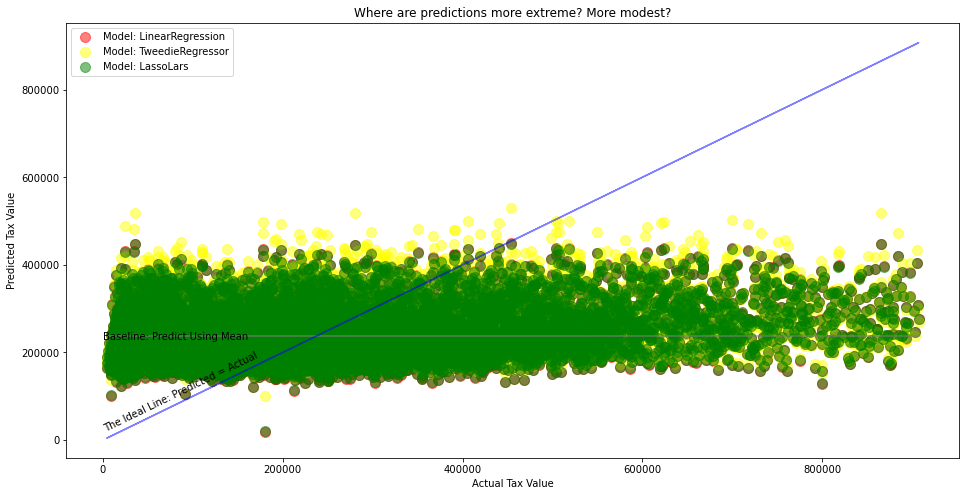

In [24]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.tax_value_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 230000))
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (10, 20000), rotation=26)

plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lars, alpha=.5, color="green", s=100, label="Model: LassoLars")

plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

### Going with the OLS model to use on the test set.

In [25]:
# predict test
# use the thing!
lm = LinearRegression()
# fit the thing
lm.fit(X_train_scaled, y_train.tax_value)

y_test_predictions = lm.predict(X_test_scaled)

In [26]:
# evaluate: rmse
rmse_test = mean_squared_error(y_test, y_test_predictions) ** (1/2)

### Compare RMSE values OLS model with baseline prediction.

In [27]:
print('OLS RMSE:     ', rmse_test)
print('Baseline RMSE: 197242.655712')

OLS RMSE:      187977.90459592952
Baseline RMSE: 197242.655712


### Conclusions & Recommendations

* Using RMSE as a metric for comparison, with a baseline RMSE of 197,243 and my model's RMSE of 187,977 my model is a slight improvement(~5%) on the baseline model.
* At this time I do not feel confident in recomending my model to predict the tax value of a property.

### Next Steps

* With more time I would like to test my hypothesis that geolcation of the property is an important feature to investigate.
* Incorporate location-type features to improve my model.